# Imports and Data

In [15]:
from typing import NamedTuple
import pandas as pd
from pathlib import Path
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
from functools import lru_cache


class CollegeMessage(NamedTuple):
    source: int  #source id
    target: int  # target id
    unix_timestamp: int  # seconds after last epoc


def read_message_data(datapath: str) -> list[CollegeMessage]:
    filepath = Path.cwd() / Path(datapath)

    if not filepath.exists():
        raise FileNotFoundError(
            f"File not found: {filepath}; " +
            f"Current working directory: {Path.cwd()}; " +
            f"Relative path to data file: {Path(datapath)}"
        )

    print(f"Using file: {filepath.absolute()}")

    messages = []
    with open(filepath, 'r', encoding="UTF-8") as f:
        for line in f:
            source, target, timestamp = line.strip().split()
            messages.append(CollegeMessage(int(source), int(target), int(timestamp)))
    print("done")
    return messages


def remove_low_degree_nodes(data: pd.DataFrame, min_degree: int) -> pd.DataFrame:
    in_degree = data['target'].value_counts()
    out_degree = data['source'].value_counts()
    high_degree_nodes = set(in_degree[in_degree >= min_degree].index) & set(out_degree[out_degree >= min_degree].index)
    return data[data['source'].isin(high_degree_nodes) & data['target'].isin(high_degree_nodes)]


def create_graph(data: pd.DataFrame) -> nx.DiGraph:
    digraph = nx.DiGraph()

    for row in data.itertuples(index=False):
        digraph.add_edge(row.source, row.target, timestamp=row.unix_timestamp)

    return digraph


def graph_figure(graph: nx.DiGraph):
    pos = nx.arf_layout(graph)
    nx.draw(graph, pos, with_labels=False, node_size=10)


# Layout calculations, cached by LRU to avoid recalculating the layout
@lru_cache(maxsize=None)
def cache_layout(graph: nx.DiGraph, layout_func: callable):
    print("Calculating layout ...")
    layout = layout_func(graph)
    print("... done calculating layout")
    return layout

In [16]:
_DATA_PATH = "./dataset/CollegeMsg.txt"

_MESSAGES = read_message_data(_DATA_PATH)

DF_MESSAGES = remove_low_degree_nodes(pd.DataFrame(_MESSAGES), 2)

GRAPH_MESSAGES = create_graph(DF_MESSAGES)

Using file: /home/mojmir-majer/projects/private/github/rug-sna-pizza-giving/college_msg_files/dataset/CollegeMsg.txt
done


In [17]:
DF_MESSAGES.head()

,source,target,unix_timestamp
39,41,42,1082574211
48,36,50,1082597715
49,44,51,1082597751
50,32,52,1082598056
51,36,32,1082598122


# Time window

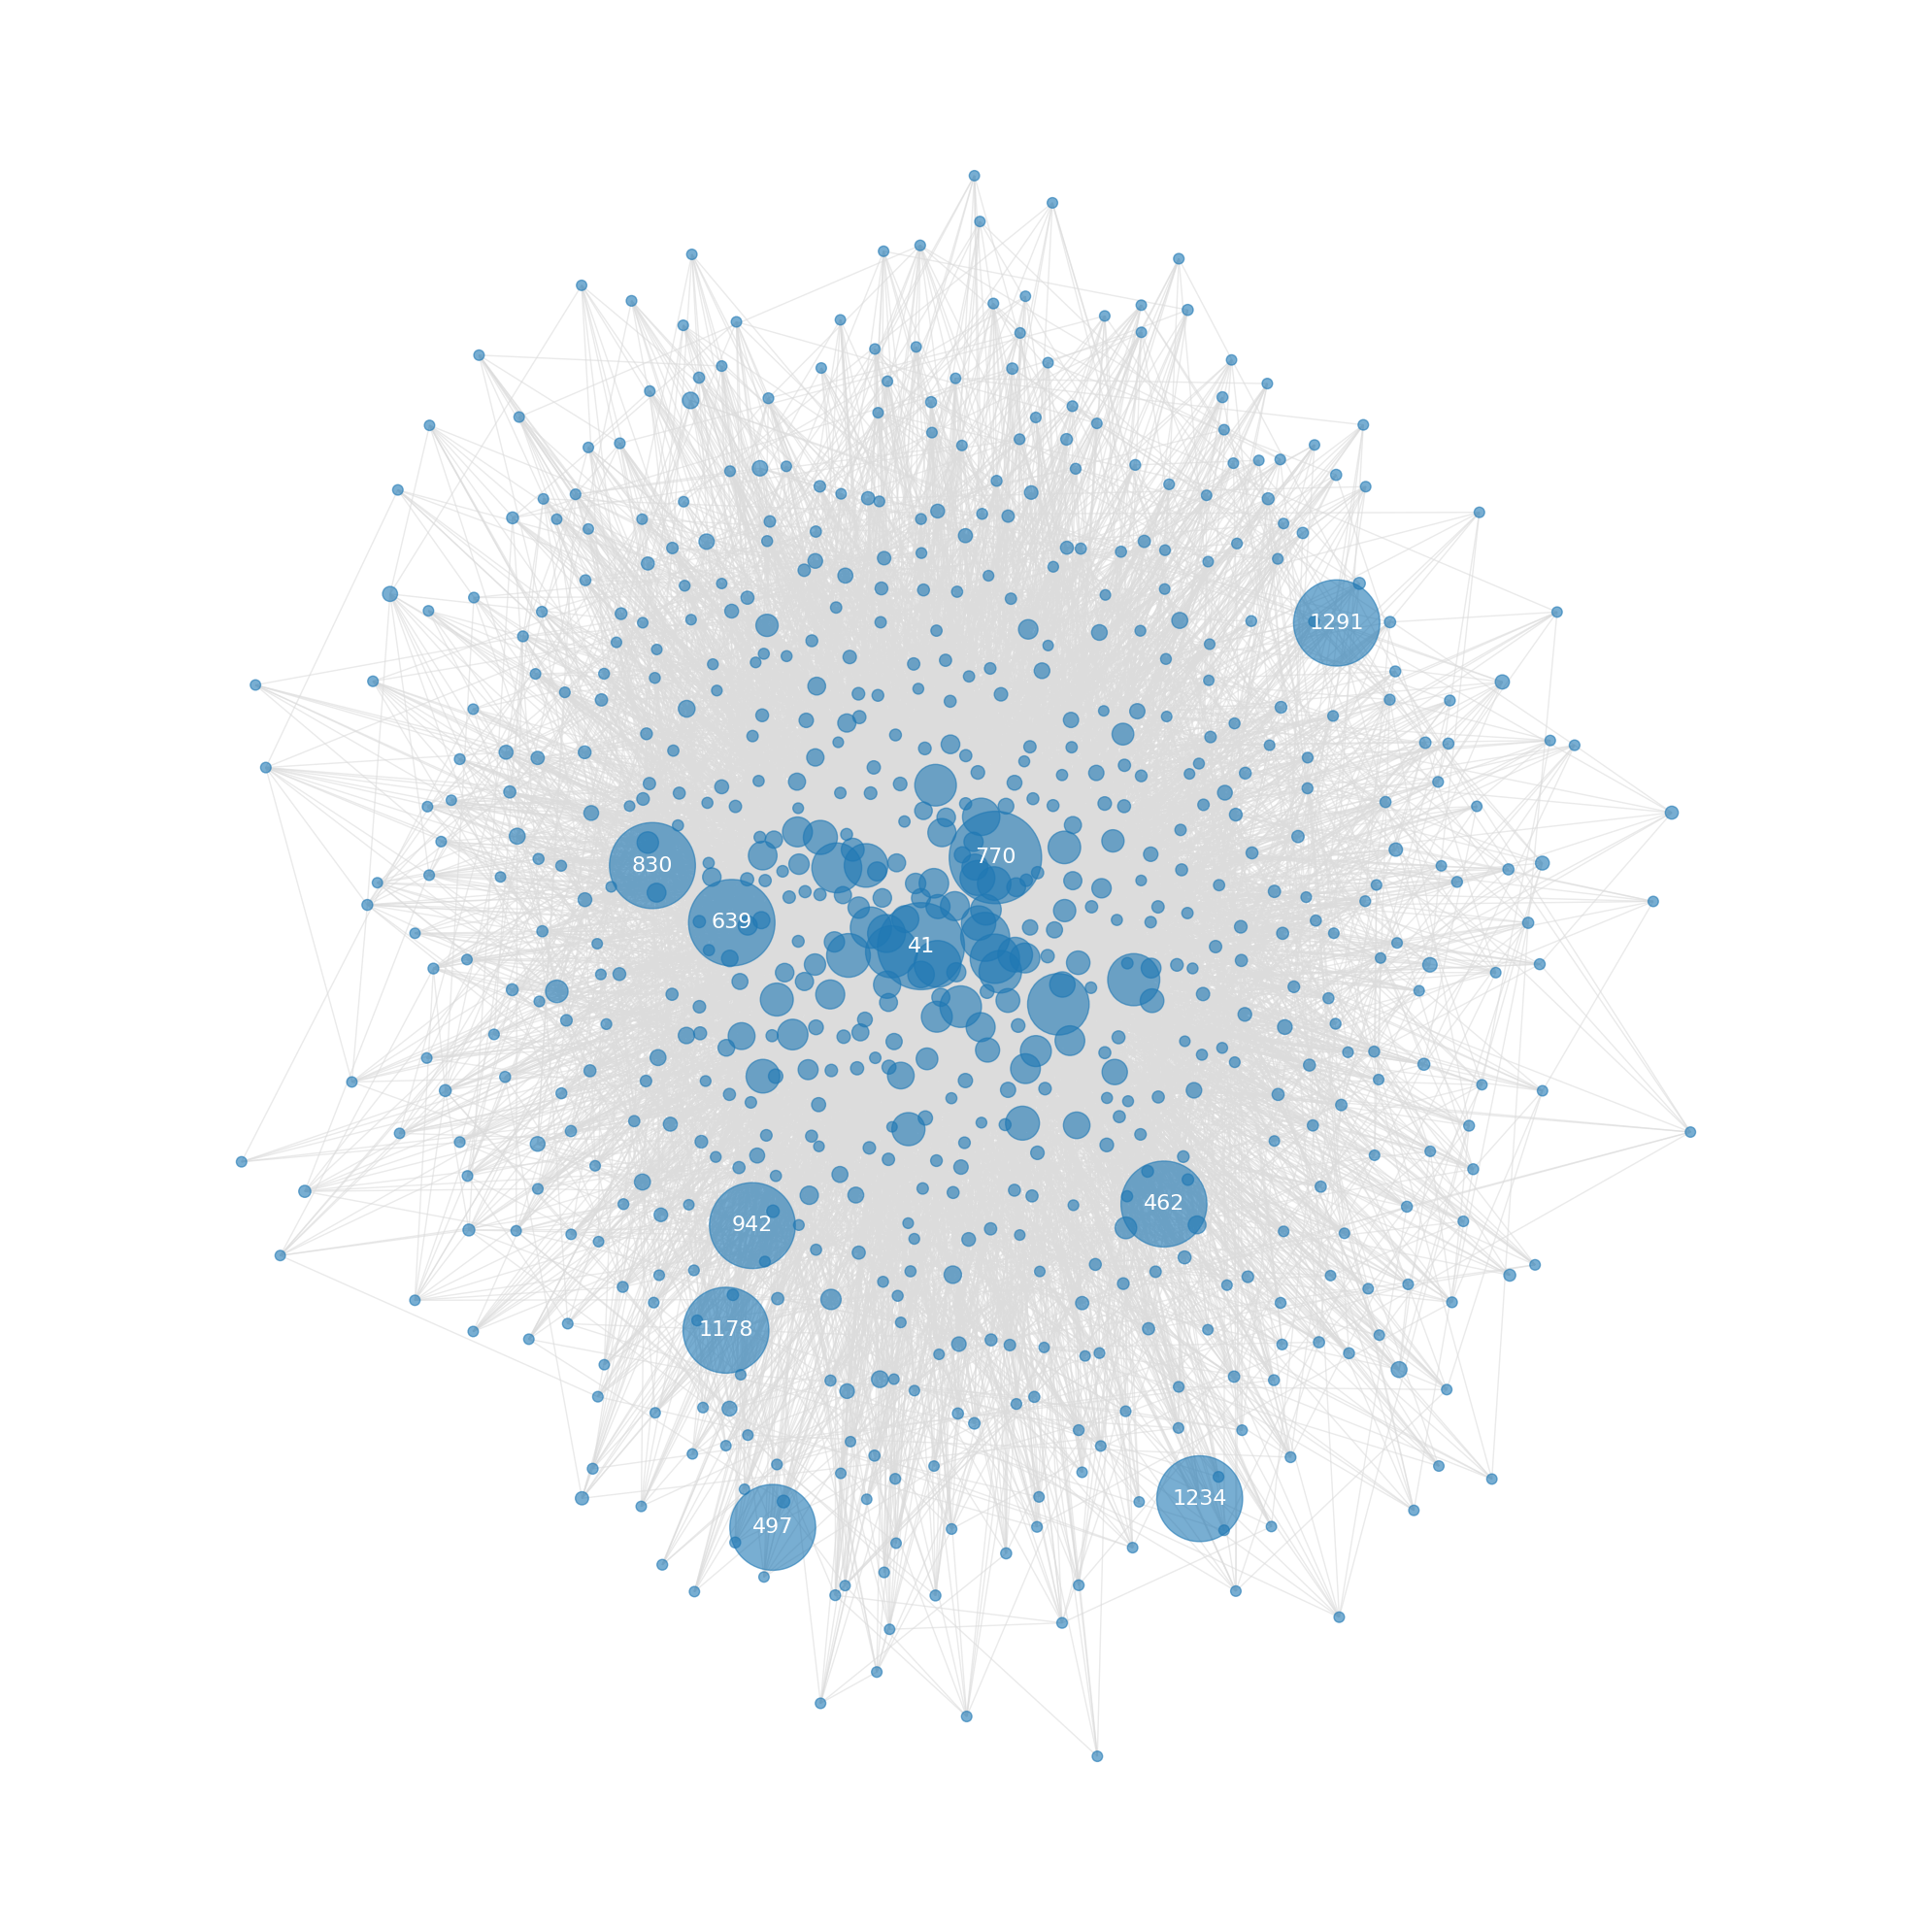

In [18]:
import networkx as nx
import matplotlib.pyplot as plt

def beetweenness(G: nx.Graph):    
    # Remove low-degree nodes
    low_degree = [n for n, d in G.degree() if d < 10]
    G.remove_nodes_from(low_degree)
    
    # Largest connected component
    components = nx.connected_components(G)
    largest_component = max(components, key=len)
    H = G.subgraph(largest_component)
    
    # Compute centrality
    centrality = nx.betweenness_centrality(H, k=10, endpoints=True)
    
    # Find top 10 nodes by betweenness centrality
    top_10_nodes = sorted(centrality, key=centrality.get, reverse=True)[:10]
    
    #### Draw graph ####
    fig, ax = plt.subplots(figsize=(20, 20))
    pos = nx.spring_layout(H, k=0.15, seed=4572321)
    node_size = [v * 40000 for v in centrality.values()]
    
    nx.draw_networkx(
        H,
        pos=pos,
        with_labels=False,
        node_size=node_size,
        edge_color="gainsboro",
        alpha=0.6,
    )
    
    # Add labels for top 10 nodes
    nx.draw_networkx_labels(H, pos, labels={n: n for n in top_10_nodes}, font_size=16, font_color="white")
    
    # Resize figure for label readability
    ax.margins(0.1, 0.05)
    fig.tight_layout()
    plt.axis("off")
    plt.savefig("./.export/betweenness.png")
    plt.show()


beetweenness(nx.Graph(GRAPH_MESSAGES))

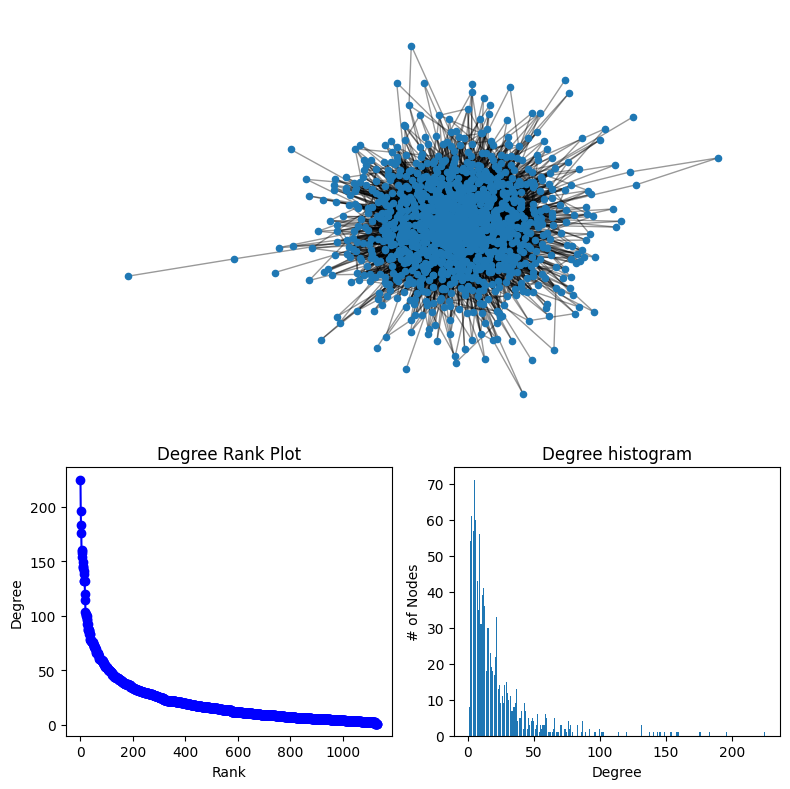

In [22]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

def degree_analysis(G: nx.Graph):
    degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
    dmax = max(degree_sequence)
    
    fig = plt.figure("Degree of a random graph", figsize=(8, 8))
    # Create a gridspec for adding subplots of different sizes
    axgrid = fig.add_gridspec(5, 4)
    
    ax0 = fig.add_subplot(axgrid[0:3, :])
    Gcc = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])
    pos = nx.spring_layout(Gcc, seed=10396953)
    nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20)
    nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)
    # ax0.set_title("Connected components of G")
    ax0.set_axis_off()
    
    ax1 = fig.add_subplot(axgrid[3:, :2])
    ax1.plot(degree_sequence, "b-", marker="o")
    ax1.set_title("Degree Rank Plot")
    ax1.set_ylabel("Degree")
    ax1.set_xlabel("Rank")
    
    ax2 = fig.add_subplot(axgrid[3:, 2:])
    ax2.bar(*np.unique(degree_sequence, return_counts=True))
    ax2.set_title("Degree histogram")
    ax2.set_xlabel("Degree")
    ax2.set_ylabel("# of Nodes")
    
    fig.tight_layout()
    plt.savefig("./.export/degrees.png")
    plt.show()
    
degree_analysis(nx.Graph(GRAPH_MESSAGES))

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx

def directed(G: nx.DiGraph):
    pos = nx.spring_layout(G)
    
    node_sizes = [3 + 10 * i for i in range(len(G))]
    M = G.number_of_edges()
    edge_colors = range(2, M + 2)
    edge_alphas = [(5 + i) / (M + 4) for i in range(M)]
    cmap = plt.cm.plasma
    
    nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color="indigo")
    edges = nx.draw_networkx_edges(
        G,
        pos,
        node_size=node_sizes,
        arrowstyle="->",
        arrowsize=10,
        edge_color=edge_colors,
        edge_cmap=cmap,
        width=2,
    )
    # set alpha value for each edge
    for i in range(M):
        edges[i].set_alpha(edge_alphas[i])
    
    pc = mpl.collections.PatchCollection(edges, cmap=cmap)
    pc.set_array(edge_colors)
    
    ax = plt.gca()
    ax.set_axis_off()
    plt.colorbar(pc, ax=ax)
    plt.show()
    
directed(nx.DiGraph(GRAPH_MESSAGES))